# DCGAN Training Tutorials

This tutorial is based on Pytorch DCGAN Tutorial.

Tutorial Goal: Learn how to train GAN and visualize the result.

## 1. Settings

### 1.1 Import required library

In [70]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### 1.2 Set seed for reproducibility

In [71]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


## 2. Prepare Datasets

In [144]:
# Hyperparameters
image_size = 64
batch_size = 100

# Data preprocesssing
img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loader
train_dataset = dset.MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = dset.MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 3. Define Models for Generator and Discriminator

### 3.1 Define Generator and Discriminator Class

In [145]:
class Generator(nn.Module):
    def __init__(self, latent_dim = 100, channel_dim=128, output_dim=1):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, channel_dim*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(channel_dim*8)
        self.deconv2 = nn.ConvTranspose2d(channel_dim*8, channel_dim*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(channel_dim*4)
        self.deconv3 = nn.ConvTranspose2d(channel_dim*4, channel_dim*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(channel_dim*2)
        self.deconv4 = nn.ConvTranspose2d(channel_dim*2, channel_dim, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(channel_dim)
        self.deconv5 = nn.ConvTranspose2d(channel_dim, output_dim, 4, 2, 1)

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, channel_dim=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, channel_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(channel_dim, channel_dim*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(channel_dim*2)
        self.conv3 = nn.Conv2d(channel_dim*2, channel_dim*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(channel_dim*4)
        self.conv4 = nn.Conv2d(channel_dim*4, channel_dim*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(channel_dim*8)
        self.conv5 = nn.Conv2d(channel_dim*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

### 3.2 Build Generator and Discriminator model

In [146]:
# Generator and Discriminator
channel_dim = 128
latent_dim = 100
output_dim = 1

generator = Generator(latent_dim = latent_dim, channel_dim = channel_dim, output_dim = output_dim)
discriminator = Discriminator(channel_dim = channel_dim)

# Use GPU or CPU
use_gpu = True
device = torch.device("cuda:7" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

### 3.3 Check model parameters

In [147]:
num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


### 3.4 Weight initialization function

In [156]:
# custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 3.5 Apply weight initialization on Generator and Discriminator

In [157]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

### 3.6 Loss function and Optimizer

In [158]:
learning_rate = 1e-4
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate)
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))

## 4. Train DCGAN

### 4.1 Fix latent noise for visualization

In [159]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device = device)

### 4.2 Train Generator and Discriminator over training dataset

In [ ]:
# set training epochs
num_epochs = 5

# set to training mode
generator.train()
discriminator.train()

gen_losses = []
disc_losses = []
img_list = []
iters = 0

print('Training ...')
for epoch in range(num_epochs):

    for i, (image_batch, _) in enumerate(train_dataloader):

        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            criterion(real_pred, label_real) +
            criterion(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = criterion(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        #gen_loss_avg[-1] += gen_loss.item()
        #disc_loss_avg[-1] += disc_loss.item()
        #num_batches += 1
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     disc_loss.item(), gen_loss.item()))

        # Save losses for plotting
        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())

        # Check how the generator is doing by saving G's output on fixed noise
        if iters % 500 == 0 or (epoch == num_epochs-1):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vtils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Training ...
[0/5][0/600]	Loss_D: 1.2904	Loss_G: 4.5393
[0/5][50/600]	Loss_D: 0.0013	Loss_G: 13.0178
[0/5][100/600]	Loss_D: 0.0022	Loss_G: 63.2358
[0/5][150/600]	Loss_D: 0.0000	Loss_G: 53.2692
[0/5][200/600]	Loss_D: 0.0000	Loss_G: 52.3992
[0/5][250/600]	Loss_D: 0.0000	Loss_G: 51.7318
[0/5][300/600]	Loss_D: 0.0000	Loss_G: 50.9134
[0/5][350/600]	Loss_D: 0.0000	Loss_G: 49.1852
[0/5][400/600]	Loss_D: 0.0000	Loss_G: 47.6594
[0/5][450/600]	Loss_D: 0.0000	Loss_G: 53.8696
[0/5][500/600]	Loss_D: 0.0429	Loss_G: 8.1942
[0/5][550/600]	Loss_D: 0.0040	Loss_G: 9.1299
[1/5][0/600]	Loss_D: 0.0044	Loss_G: 8.2726
[1/5][50/600]	Loss_D: 0.0110	Loss_G: 20.9306
[1/5][100/600]	Loss_D: 0.0314	Loss_G: 22.8556
[1/5][150/600]	Loss_D: 0.0003	Loss_G: 15.5851
[1/5][200/600]	Loss_D: 0.0004	Loss_G: 10.8158
[1/5][250/600]	Loss_D: 0.5537	Loss_G: 5.4971
[1/5][300/600]	Loss_D: 0.0021	Loss_G: 8.2216
[1/5][350/600]	Loss_D: 0.0001	Loss_G: 27.5707
[1/5][400/600]	Loss_D: 0.0093	Loss_G: 16.3246
[1/5][450/600]	Loss_D: 0.0003	Los

## 5. Visualizing Training Results

### 5.1 Loss vs. training iteration

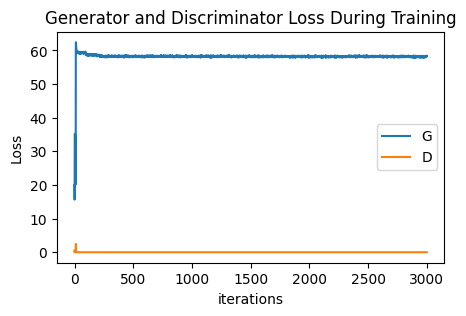

In [120]:
plt.figure(figsize=(5,3))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 5.2 Visualization of Generator output

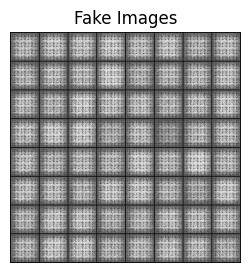

In [121]:
generator.eval()

# Sample random noise
random_noise = torch.randn(64, latent_dim, 1, 1, device = device)

# Generate image using Generator
fake_image = generator(random_noise).detach().cpu()
fake_image = vtils.make_grid(fake_image, padding=2, normalize=True)

fig = plt.figure(figsize=(3,3))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_image, (1, 2, 0)))
plt.show()

### 5.3 Real Images vs. Generated Images

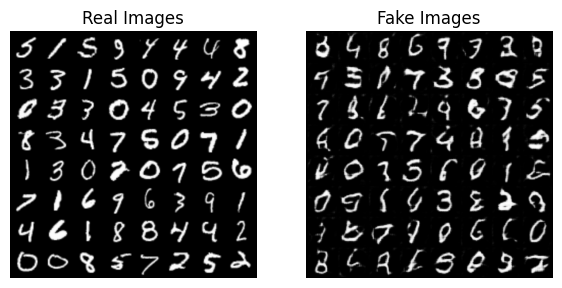

In [107]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vtils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### 5.4 Interpolation in latent space

In [108]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

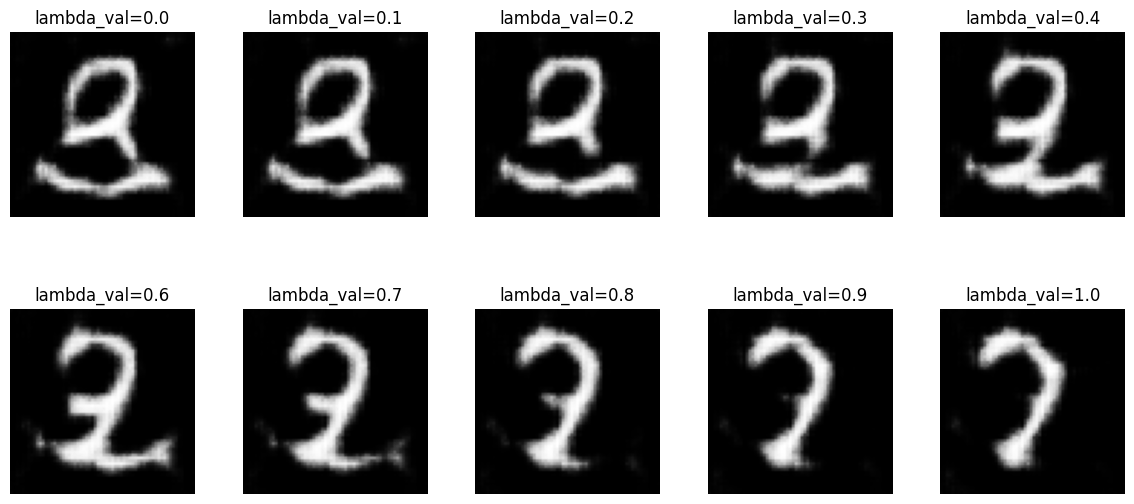

In [111]:
plt.ion()
generator.eval()

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dims, 1, 1, device=device)
latent_2 = torch.randn(1, latent_dims, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), generator, latent_1, latent_2)

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')

plt.show()